# Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sys
sys.path.append('../../')
sys.path.append('../../source_code')
from source_code.utils import current_timestamp

In [2]:
data_path = '/Users/jeremy/data/'
file_name = 'seti_breakthrough_listen_et'
data_path = data_path + file_name

In [3]:
TARGET = 'target'

In [4]:
def get_train_file_path(image_id):
    return f"{data_path}/train/{image_id[0]}/{image_id}.npy"

def get_test_file_path(image_id):
    return f"{data_path}/test/{image_id[0]}/{image_id}.npy"

In [5]:
train = pd.read_csv(data_path + '/train_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
train['file_path'] = train['file_path']#.str.split(prefix).str[-1]

test = pd.read_csv(data_path + '/sample_submission.csv')
test['file_path'] = test['id'].apply(get_test_file_path)
test['file_path'] = test['file_path']#.str.split(prefix).str[-1]

In [6]:
train_df, validation_df = train_test_split(train, test_size=0.2)

In [7]:
train_size = int(train_df.shape[0])
validation_size = int(validation_df.shape[0]/5)
test_size = int(test.shape[0])
print(train_size, validation_size, test_size)

3361 3311 716


In [8]:
train_examples = []
validation_examples = []
test_examples = []

train_labels = []
validation_labels = []
test_indexes = []

for i in tqdm(train_df.index[:train_size].to_list()):
    train_examples.append(np.load(train_df.loc[i,'file_path']).reshape(6,273,256))
    train_labels.append(train_df.loc[i,TARGET])

for i in tqdm(validation_df.index[:validation_size].to_list()):
    validation_examples.append(np.load(validation_df.loc[i,'file_path']).reshape(6,273,256))
    validation_labels.append(validation_df.loc[i,TARGET])

for i in tqdm(test.index[:test_size].to_list()):
    test_examples.append(np.load(test.loc[i,'file_path']).reshape(6,273,256))
    test_indexes.append(test.loc[i, 'id'])

100%|██████████| 716/716 [00:01<00:00, 415.08it/s]


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_examples, validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(test_examples)

2021-07-31 23:26:32.235682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100
EPOCHS = 25

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['target'].values),
                                                  train['target'].values)
class_weights = dict(enumerate(class_weights))
class_weights[1] = class_weights[1]*0.35
class_weights

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{0: 0.5516153152558774, 1: 1.8702332765232208}

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import save_model

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(6, 273, 256)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 271, 32)        73760     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 135, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 135, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8640)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1106048   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,179,937
Trainable params: 1,179,937
Non-trainable params: 0
______________________________________________

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

In [14]:
callbacks = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True,)
model.fit(train_dataset, epochs=EPOCHS, validation_data = validation_dataset, callbacks=[callbacks], class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-07-31 23:31:54.497421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
169/169 [==============================] - 26s 152ms/step - loss: 0.6792 - auc: 0.5459 - val_loss: 0.6566 - val_auc: 0.5407

In [15]:
# save model
current_timestamp_ = current_timestamp()
save_model(model, f'cnn_model_{current_timestamp_}.h5')

In [16]:
losses = pd.DataFrame(model.history.history)
losses

,loss,auc,val_loss,val_auc
0,0.679,0.546,0.657,0.541
1,0.395,0.665,0.463,0.558
2,0.345,0.767,0.481,0.525
3,0.311,0.821,0.735,0.533
4,0.304,0.830,0.575,0.534


<AxesSubplot:>

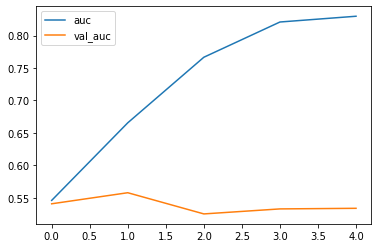

In [17]:
losses[['auc','val_auc']].plot()

<AxesSubplot:>

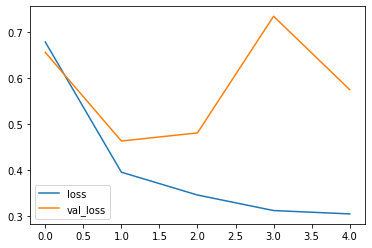

In [18]:
losses[['loss','val_loss']].plot()

In [19]:
preds = model.predict(validation_dataset).flatten()

In [20]:
binary_preds = (preds > 0.5).astype(int)
confusion_matrix(validation_labels, binary_preds)

array([[2607,  410],
       [ 234,   60]])

In [21]:
print(classification_report(validation_labels, binary_preds))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3017
           1       0.13      0.20      0.16       294

    accuracy                           0.81      3311
   macro avg       0.52      0.53      0.52      3311
weighted avg       0.85      0.81      0.82      3311



In [22]:
print(validation_examples[0].shape, test_examples[0].shape)
print(len(validation_examples), len(test_examples))

(6, 273, 256) (6, 273, 256)
3311 716


In [23]:
submission_pred = model.predict(test_dataset).flatten()

array([1.98278338e-01, 5.76268792e-01, 6.30498827e-01, 8.43926966e-02,
       9.76532698e-03, 2.94369459e-02, 7.37025142e-02, 4.97637570e-01,
       2.04925239e-01, 3.58180046e-01, 1.08675957e-02, 3.95321071e-01,
       5.26899099e-03, 4.81960177e-02, 8.15721333e-01, 1.90044045e-02,
       4.16787803e-01, 1.08953685e-01, 1.51729554e-01, 1.24308974e-01,
       3.38029504e-01, 1.36655182e-01, 3.23290944e-01, 4.95832860e-02,
       2.69175768e-02, 1.56088829e-01, 1.97213888e-02, 4.98382866e-01,
       4.47645187e-02, 7.86891222e-01, 1.61351383e-01, 2.43990421e-01,
       8.18902850e-02, 1.92679167e-02, 3.38326633e-01, 1.50219679e-01,
       2.55572617e-01, 4.57768440e-02, 5.68499148e-01, 1.13774836e-02,
       9.17780221e-01, 3.62832546e-02, 1.19638741e-02, 6.73957407e-01,
       8.98669064e-02, 3.19778085e-01, 3.82672846e-02, 3.45850050e-01,
       1.68361664e-02, 4.11778748e-01, 6.88385725e-01, 2.33059108e-01,
       8.35978985e-02, 7.43654370e-02, 3.26323509e-01, 4.92722481e-01,
      

In [24]:
submission = pd.DataFrame([test_indexes, submission_pred], index=['id','target']).T
submission.to_csv(f'submission_{current_timestamp_}.csv')
submission

,id,target
0,00034db451c4,0.198
1,0006316b5ca0,0.576
2,0006a953d21b,0.630
3,0008a33d6695,0.084
4,00095b5119fc,0.010
...,...,...
711,04ff98f3fd3f,0.747
712,0500fc2b8eed,0.256
713,050340e057a2,0.231
714,050647920d9e,0.040
